# Code

## Loading Model

In [ ]:
%%capture
!pip install langchain>=0.1.17 openai>=1.13.3 langchain_openai>=0.1.6 transformers>=4.40.1 datasets>=2.18.0 accelerate>=0.27.2 sentence-transformers>=2.5.1 duckduckgo-search>=5.2.2
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
    temperature=0
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

# Create a pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=5,
    do_sample=False,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Device set to use cuda


## Iteration 1

In [ ]:
# use pipe(all_prompts, batch_size=16) to maximize gpu
import json
import re

with open('nouns.txt') as file:
    nouns = [line.rstrip() for line in file]

with open('properties.txt') as file:
    properties = [line.rstrip() for line in file]

with open('baseline-prompts.jsonl') as file:
    baselines = [json.loads(line) for line in file]

prompts = []
raw_bl_outputs = []
clean_bl_outputs = []

for noun in nouns:
    for baseline in baselines:
        prompt = [
            {"role": "system", "content": "Please only output a singular number. \
            If you cannot provide a rating, answer 1."},
            {"role": "user", "content": f'{baseline["pre-prompt"]}{noun}?'}
        ]
        rating = pipe(prompt)[0]["generated_text"]
        raw_bl_outputs.append([baseline["property"], noun, rating])
    # print(f'Progress: {noun} \n')

with open('baseline-output.txt', 'w') as file:
    for prop, noun, rating in raw_bl_outputs:
        rating = int(rating.strip())
        clean_bl_outputs.append([prop, noun, rating])
        file.write(f'{prop}, {noun}, {rating}\n')



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# for output in clean_bl_outputs:
#     print(output)

### Plots

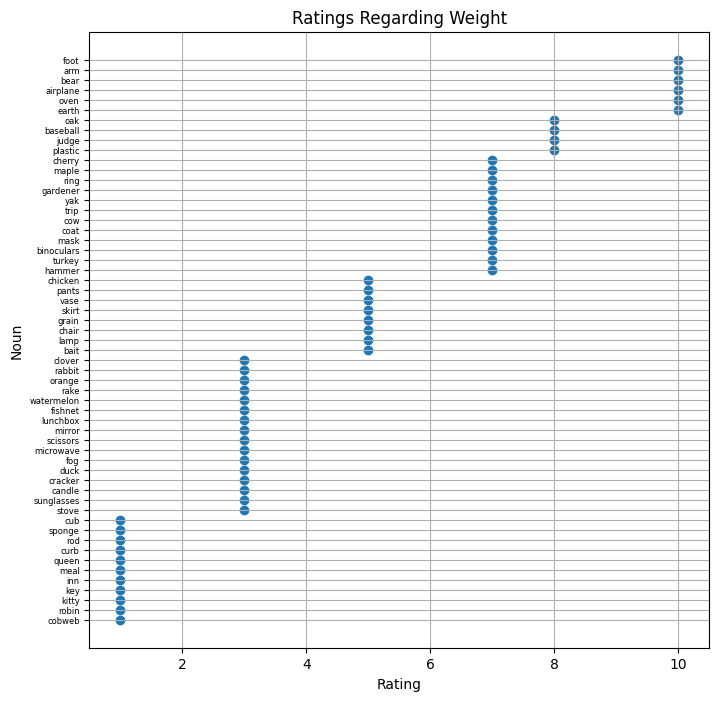

In [ ]:
import matplotlib.pyplot as plt

bl_weight = [(noun, int(rating)) for prop, noun, rating in clean_bl_outputs if prop == "weight"]
bl_usefulness = [(noun, int(rating)) for prop, noun, rating in clean_bl_outputs if prop == "usefulness"]
bl_durability = [(noun, int(rating)) for prop, noun, rating in clean_bl_outputs if prop == "durability"]
bl_carbon_footprint = [(noun, int(rating)) for prop, noun, rating in clean_bl_outputs if prop == "carbon-footprint"]
bl_edibleness = [(noun, int(rating)) for prop, noun, rating in clean_bl_outputs if prop == "edibleness"]

sorted_bl_weight = sorted(bl_weight, key=lambda x: x[1])
bl_nouns = [noun for noun, rating in sorted_bl_weight]
bl_ratings = [rating for noun, rating in sorted_bl_weight]

plt.figure(figsize=(8, 8))
plt.scatter(bl_ratings, bl_nouns)

plt.xlim(0.5, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Ratings Regarding Weight')
plt.tick_params(axis='y', labelsize=6)
plt.grid()

plt.show()


> Regarding weight, it appears as though there is a fairly good distribution of the data. Items like "cobweb" were fairly rated as being on the lowest tier, and "earth" was likewise on the highest tier. However, items like "inn" should be much higher than a rating of 1, especially when "rabbit" is at 3. There seem to be inconsistencies, especially when certain nouns can grow at different points of life.

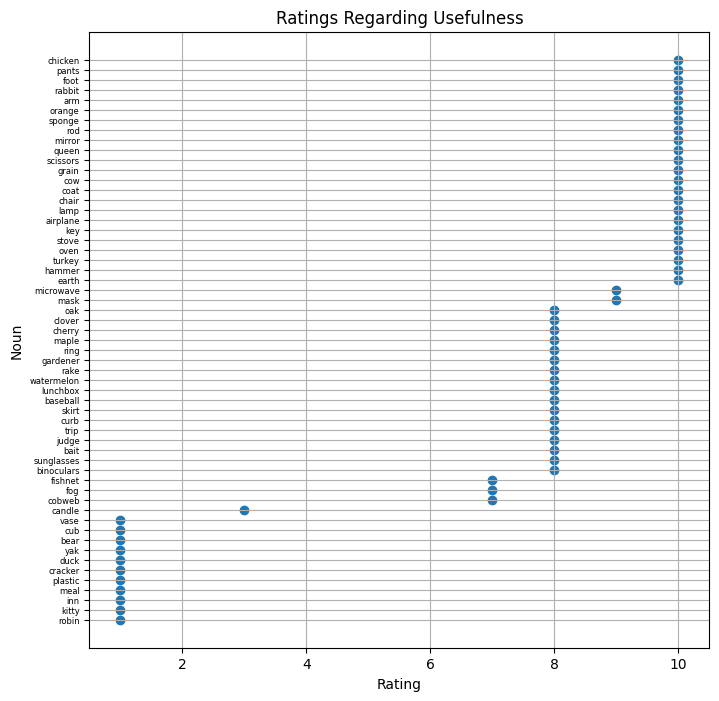

In [ ]:
sorted_bl_usefulness = sorted(bl_usefulness, key=lambda x: x[1])
bl_nouns = [noun for noun, rating in sorted_bl_usefulness]
bl_ratings = [rating for noun, rating in sorted_bl_usefulness]

plt.figure(figsize=(8, 8))
plt.scatter(bl_ratings, bl_nouns)

plt.xlim(0.5, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Ratings Regarding Usefulness')
plt.tick_params(axis='y', labelsize=6)
plt.grid()

plt.show()

> The ratings for usefulness were much more promising than the results for weight. A majority of the items were rated by a singular number. Items such as "hammer" and "scissors" are indeed very useful, and they were properly noted as 10s on our scale. On the other hand, items such as "plastic" struggled to be judged by the model, as it is a very useful invention. There may need to be a clarifying note about ingredients, but the performance is overall good.

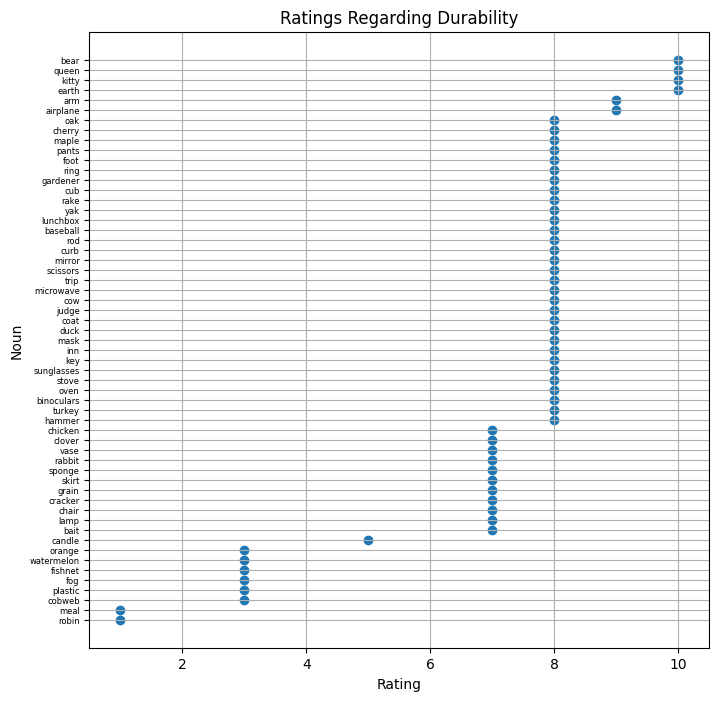

In [ ]:
sorted_bl_durability = sorted(bl_durability, key=lambda x: x[1])
bl_nouns = [noun for noun, rating in sorted_bl_durability]
bl_ratings = [rating for noun, rating in sorted_bl_durability]

plt.figure(figsize=(8, 8))
plt.scatter(bl_ratings, bl_nouns)

plt.xlim(0.5, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Ratings Regarding Durability')
plt.tick_params(axis='y', labelsize=6)
plt.grid()

plt.show()

> The ratings for durability seemed to perform the best out of all of the categories. Body parts such as "foot" and "arm" were correctly labeled as very durable, surpisingly, and items like "earth" were at the top of the list, as the earth has survived for quite a long time. Oddly, "kitty" and "queen" were noted as very durable, but this may be due to confusion by the LLM.

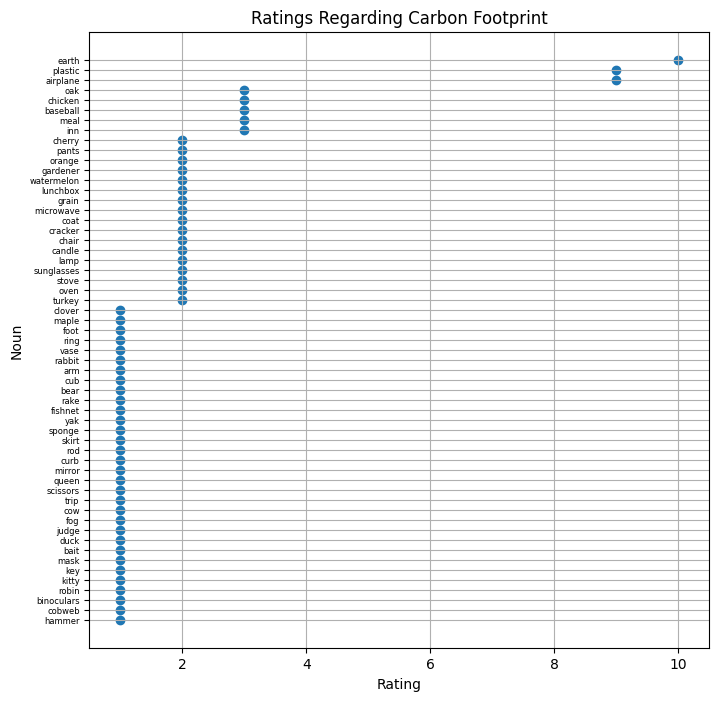

In [ ]:
sorted_bl_carbon_footprint = sorted(bl_carbon_footprint, key=lambda x: x[1])
bl_nouns = [noun for noun, rating in sorted_bl_carbon_footprint]
bl_ratings = [rating for noun, rating in sorted_bl_carbon_footprint]

plt.figure(figsize=(8, 8))
plt.scatter(bl_ratings, bl_nouns)

plt.xlim(0.5, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Ratings Regarding Carbon Footprint')
plt.tick_params(axis='y', labelsize=6)
plt.grid()

plt.show()

> Regarding carbon footprint, it was expected that there would not be a large deviation in the data. Living nouns are going to have a minimal impact, and we see this with "cow" and "yak." Likewise, "plastic" and "airplane" both scored as having high footprints, as expected. There is not much wrong in this example.

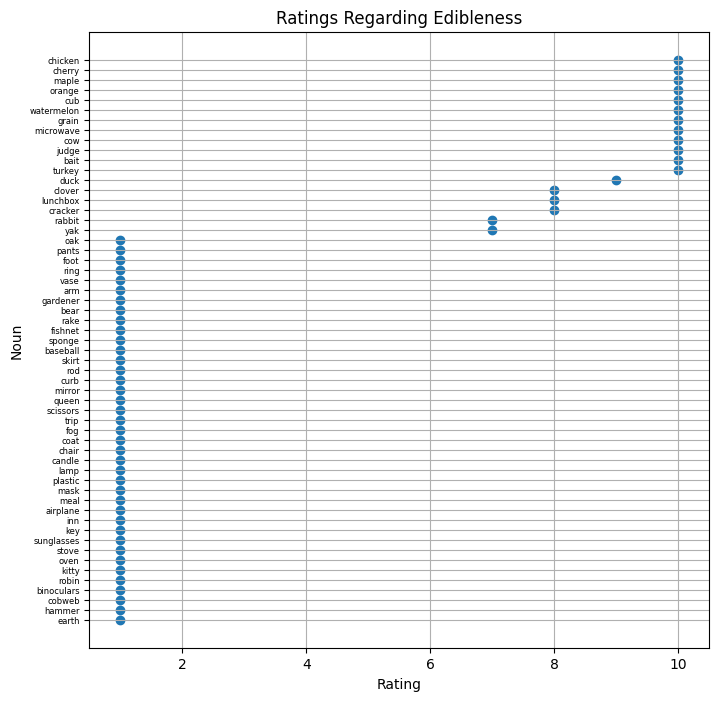

In [ ]:
sorted_bl_edibleness = sorted(bl_edibleness, key=lambda x: x[1])
bl_nouns = [noun for noun, rating in sorted_bl_edibleness]
bl_ratings = [rating for noun, rating in sorted_bl_edibleness]

plt.figure(figsize=(8, 8))
plt.scatter(bl_ratings, bl_nouns)

plt.xlim(0.5, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Ratings Regarding Edibleness')
plt.tick_params(axis='y', labelsize=6)
plt.grid()

plt.show()

> Lastly, the category is edibleness. Correctly, all of the food items have high ratings. Incorrectly, "bear" is rated as a 1, meaning the model did not differentiate between the living being and the meat. I believe that this category could benefit from a greatly clarified question, as almost all of the responses are 1s or 10s; I would like to have a range of values.

## Improve Prompts

In [ ]:
### improve prompts

## Iteration 2

In [ ]:
with open('improved-prompts.jsonl') as file:
    improveds = [json.loads(line) for line in file]

prompts = []
raw_im_outputs = []
clean_im_outputs = []

for noun in nouns:
    for improved in improveds:
        prompt = [
            {"role": "system", "content": "You are a scoring machine. \
              Your only valid output is an integer 1–10. Any other output is incorrect."},
            {"role": "user", "content": f'{improved["prompt"]}{noun}?'}
        ]
        rating = pipe(prompt)[0]["generated_text"]
        raw_im_outputs.append([improved["property"], noun, rating])
    # print(f'Progress: {noun} \n')

with open('improved-output.txt', 'w') as file:
    for prop, noun, rating in raw_im_outputs:
        rating = int(rating.strip())
        file.write(f'{prop}, {noun}, {rating}\n') # writing un-fixed values to file for analysis
        # if len(rating) > 3: # including this for when the model says it cannot do it. just assigning 0 to test
        #     rating = 0
        clean_im_outputs.append([prop, noun, rating])

### Plots

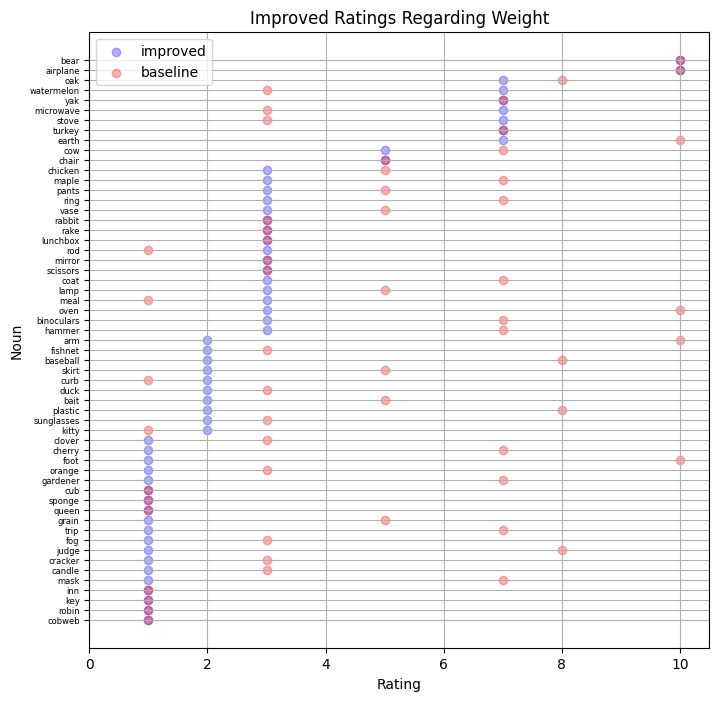

In [ ]:
im_weight = [(noun, int(rating)) for prop, noun, rating in clean_im_outputs if prop == "weight"]
im_usefulness = [(noun, int(rating)) for prop, noun, rating in clean_im_outputs if prop == "usefulness"]
im_durability = [(noun, int(rating)) for prop, noun, rating in clean_im_outputs if prop == "durability"]
im_carbon_footprint = [(noun, int(rating)) for prop, noun, rating in clean_im_outputs if prop == "carbon-footprint"]
im_edibleness = [(noun, int(rating)) for prop, noun, rating in clean_im_outputs if prop == "edibleness"]

sorted_im_weight = sorted(im_weight, key=lambda x: x[1])

im_nouns = [noun for noun, rating in sorted_im_weight]
im_ratings = [rating for noun, rating in sorted_im_weight]

bl_nouns = [noun for noun, rating in sorted_bl_weight]
bl_ratings = [rating for noun, rating in sorted_bl_weight]

plt.figure(figsize=(8, 8))

plt.scatter(im_ratings, im_nouns, color='blue', alpha=0.3, label='improved')
plt.scatter(bl_ratings, bl_nouns, color='red', alpha=0.3, label='baseline')

plt.xlim(0, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Improved Ratings Regarding Weight')
plt.tick_params(axis='y', labelsize=6)
plt.grid()
plt.legend()

plt.show()


It seems as though the improved prompt is more consistent about clear values such as "cow" or "yak" although it did not improve on vocations like "queen,"judge," or "gardener." Overall, there was in increase in performance.

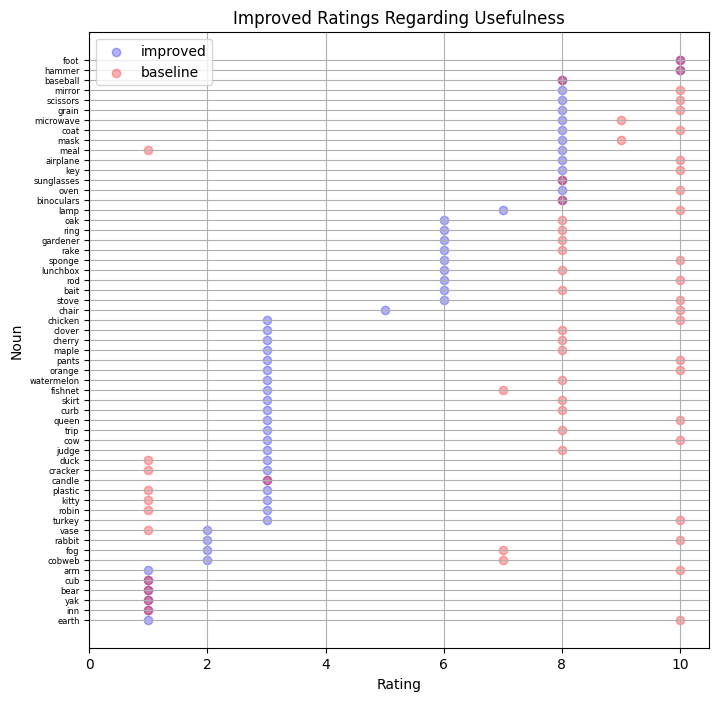

In [ ]:
sorted_im_usefulness = sorted(im_usefulness, key=lambda x: x[1])

im_nouns = [noun for noun, rating in sorted_im_usefulness]
im_ratings = [rating for noun, rating in sorted_im_usefulness]

bl_nouns = [noun for noun, rating in sorted_bl_usefulness]
bl_ratings = [rating for noun, rating in sorted_bl_usefulness]

plt.figure(figsize=(8, 8))

plt.scatter(im_ratings, im_nouns, color='blue', alpha=0.3, label='improved')
plt.scatter(bl_ratings, bl_nouns, color='red', alpha=0.3, label='baseline')

plt.xlim(0, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Improved Ratings Regarding Usefulness')
plt.tick_params(axis='y', labelsize=6)
plt.grid()
plt.legend()

plt.show()

The improved prompts did much better than the baseline prompts, creating a more even spread of values. The baseline values were clumped on two extremes, whereas almost every rating value is occupied by an improved prompt output. Again, the higher the rating, the more correct the values appear to be.

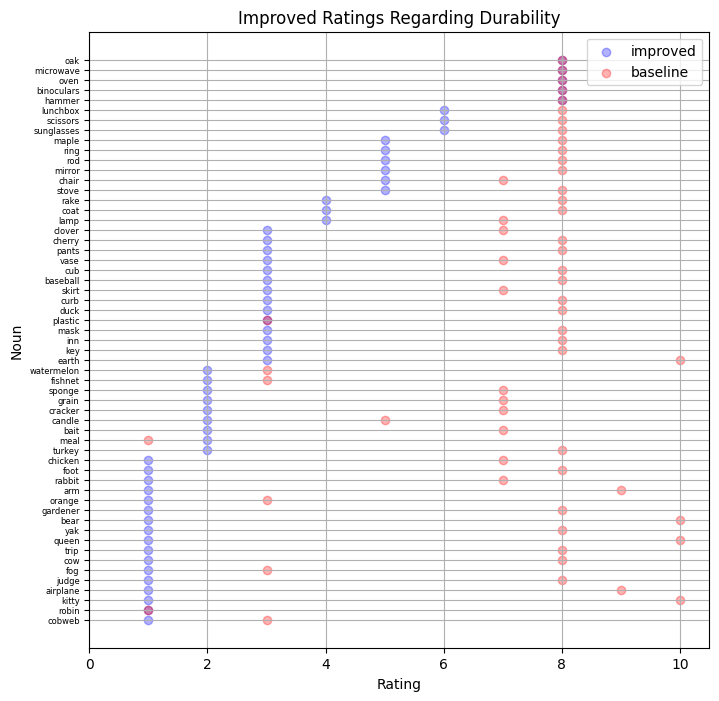

In [ ]:
sorted_im_durability = sorted(im_durability, key=lambda x: x[1])

im_nouns = [noun for noun, rating in sorted_im_durability]
im_ratings = [rating for noun, rating in sorted_im_durability]

bl_nouns = [noun for noun, rating in sorted_bl_durability]
bl_ratings = [rating for noun, rating in sorted_bl_durability]

plt.figure(figsize=(8, 8))

plt.scatter(im_ratings, im_nouns, color='blue', alpha=0.3, label='improved')
plt.scatter(bl_ratings, bl_nouns, color='red', alpha=0.3, label='baseline')

plt.xlim(0, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Improved Ratings Regarding Durability')
plt.tick_params(axis='y', labelsize=6)
plt.grid()
plt.legend()

plt.show()

Again, the improved prompt created a more even spread of rating values. Things made of wood and metal were correctly labeled at the top, and abstract values like earth were scored somewhere in the middle.

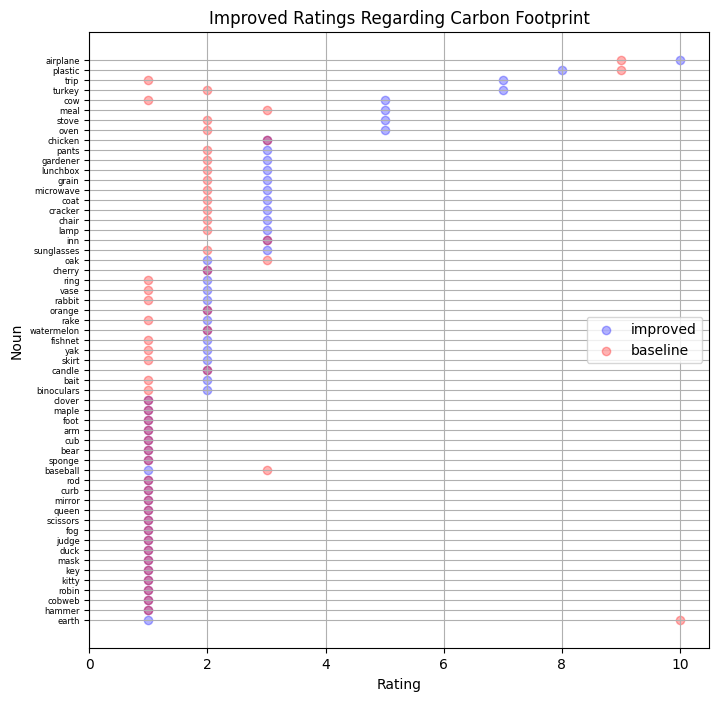

In [ ]:
sorted_im_carbon_footprint = sorted(im_carbon_footprint, key=lambda x: x[1])

im_nouns = [noun for noun, rating in sorted_im_carbon_footprint]
im_ratings = [rating for noun, rating in sorted_im_carbon_footprint]

bl_nouns = [noun for noun, rating in sorted_bl_carbon_footprint]
bl_ratings = [rating for noun, rating in sorted_bl_carbon_footprint]

plt.figure(figsize=(8, 8))

plt.scatter(im_ratings, im_nouns, color='blue', alpha=0.3, label='improved')
plt.scatter(bl_ratings, bl_nouns, color='red', alpha=0.3, label='baseline')

plt.xlim(0, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Improved Ratings Regarding Carbon Footprint')
plt.tick_params(axis='y', labelsize=6)
plt.grid()
plt.legend()

plt.show()

I believe that the values for the baseline prompts and improved prompts were extremely similar, with the main distinctive being that the improved prompts filled out the center of the graph better. By definition, this is an improvement.

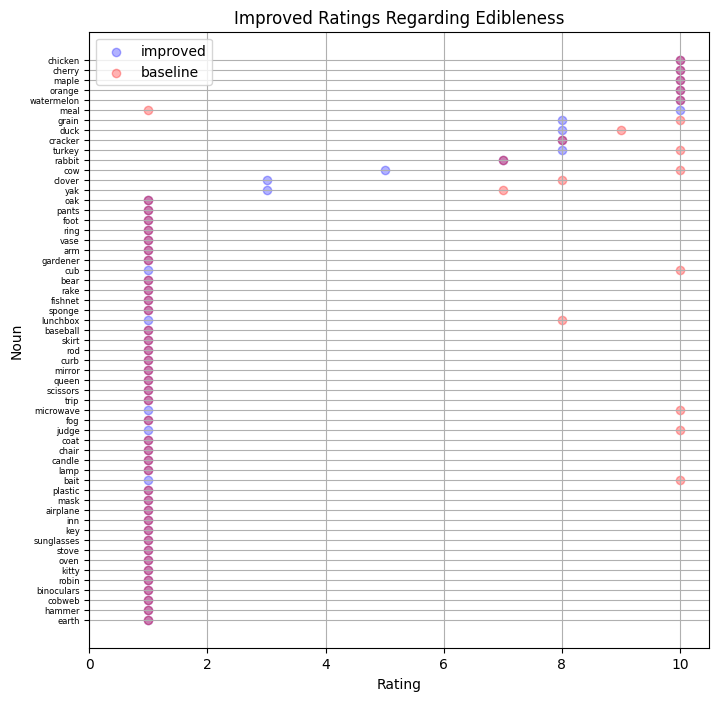

In [ ]:
sorted_im_edibleness = sorted(im_edibleness, key=lambda x: x[1])

im_nouns = [noun for noun, rating in sorted_im_edibleness]
im_ratings = [rating for noun, rating in sorted_im_edibleness]

bl_nouns = [noun for noun, rating in sorted_bl_edibleness]
bl_ratings = [rating for noun, rating in sorted_bl_edibleness]

plt.figure(figsize=(8, 8))

plt.scatter(im_ratings, im_nouns, color='blue', alpha=0.3, label='improved')
plt.scatter(bl_ratings, bl_nouns, color='red', alpha=0.3, label='baseline')

plt.xlim(0, 10.5)
plt.xlabel('Rating')
plt.ylabel('Noun')
plt.title('Improved Ratings Regarding Edibleness')
plt.tick_params(axis='y', labelsize=6)
plt.grid()
plt.legend()

plt.show()

There was not much change in regards to the edibleness graph, although the graph was, again, more filled out in the middle with the improved prompts. This is due to the few-shot prompt that showed how nouns like animals should be scored near the middle, whereas their products (meat, eggs, cheese) should be scored extremely high. This is a recurring theme.

# Final Reflection

> My method for selecting my nouns was purely using a website that generated nouns. I slightly edited the nouns to remove the proper nouns and places, in an attempt to make the nouns more similar to one another. I intentionally included nouns that were very similar but different in key areas (bear and cub, for example). I also made sure to leave in a few words that would potentially be confusing (maple, as it can be maple wood or maple syrup. Based on my analysis, the LLM assumed maple syrup).

> With that said, I wanted to select properties that would be useful for *things* specifically, although I did include person-related things as well. I will outline my intentions for each property. I will say that it was very difficult to find creative options that ranges from 1-10. First, I chose the option "weight" from a provided example; this is where I wanted to test the (successful) distinction between bear and cub. Second, I incorporated "usefulness" as a better word for "efficiency" to make note of how good a noun is to have at your disposal. Third, I chose "durability" to define the sturdiness or ability to be long-lasting. Fourth, as I was running out of creative ideas, I tested for "carbon footprint" as a measure for emissions from objects or lifeforms; I thought the results for this were very informative. Lastly, I selected "edibleness" because it could be on a range from 1-10; I was looking at various food options, so this one came to my mind. Items can range from not being consumable to being consumable and repulsive to being consumable and enjoyable.

> In regards to prompts, I want to begin by saying I spent multiple hours on step 3. I was getting numerical responses back from a good portion of the prompts, but many were not numerical, even though I asked only for numbers 1-10. I finally had a breakthrough after incorporating a system prompt that reiterated this point multiple times before submitting my user prompts for each noun and property. All of these steps resulted in my baseline prompts eventually being satisfactory.

> As a means to improve the prompt output, I scoured through the paper listed on our homework assignment webpage. I was particularly interested in the few-shot section due to the subjectiveness of some of my properties (as the original prompts were definitely zero-shot), in which I was inspired by the idea to provide examples in my prompts. I was intentional to order the exemplars from least to greatest. Depending on the property, I felt the need to include two or three examples in the range of 1-10. For example, for "weight," feather had a value of 1, and brick had a value of 6. I combined these changes with even more repetitive words in each prompt. I found that repetitive syntax online as a recommendation to ensure the LLM understood, as it was said that this particular LLM responds well that way.

> Honestly, I felt this LLM to be extremely lackluster in comparison to other popular LLMs. It seemed as though it would not understand anything I said unless it was repeated multiple times or in the same sentence as my question. This LLM's performance resulted in hours of troubleshooting for me. For nouns that only had one definition and a definitive space, the model performed very well, tending to have high accuracy. I noticed that it struggled when it came across nouns that can cover a wide range of ideas. For example, the model struggled to pinpoint the "weight" of a cub because, I think, cubs can be as tiny newborns or larger than a dog. The model would benefit from clarifying questions in these cases. At other times, its performance surprised me, like with the "carbon footprint" examples. It was intelligent enough to detect the nouns I used, consider the emissions resulted in the manufacturing of said nouns, and rate this in a 1-10 scale. Overall, I would prefer to use something like GPT-4 in every use case.

